<a href="https://colab.research.google.com/github/dtuleva/DL_23_Lectures_and_Quests/blob/main/quest_02_Explore_Data_and_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

# Quest 02 - Explore data and models
## Neural Networks for Images

I really, really like the idea of calling these side quests. Thanks to @dtuleva for the idea...
For this one, you'll have a choice of two paths which I call "the data path" and "the model path". If you ask me, both are essential to your development as people who understand ML / DL. We're on winter break so why not take both? 😄 Other than that, you could choose either one. We already covered most of the stuff in the lectures, you'll only have to implement it.



__1. The data path__

ImageDataGenerator is cool when it comes to image classification. But... it has almost no other uses. Even if you look at the docs (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), they say it's deprecated. And for a good reason. There are much better ways of loading data in tensorflow and I'm fully convinced you'll need them.

Your mission is to read the tf.data.Dataset API and learn how it works. Reconstruct the example from the lecture which reads images in directories and prepares them for classification. Assume the directory names are the class names, as shown here:

```
data/
├─ class1/
│  ├─ image1.jpg
│  ├─ 2.jpg
│  ├─ something.jpg
├─ class2/
│  ├─ image.jpg
│  ├─ image2.jpg
│  ├─ img3.jpg
```

You'll also need a way to preprocess the images (at the very, VERY least - resize them to the same dimensions and rescale them so that pixel values are [0;1]). You can do this in the data pipeline, in the inputs of the model (look at tf and keras-cv for functions you can use), or both.
The most important thing to learn is how to load only a single batch of data at a time. The following links are essential:

+ API: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
+ User guide: https://www.tensorflow.org/guide/data
+ Performance (computational speed) - I expect you'll all need something like this to work with NNs: https://www.tensorflow.org/guide/data_performance
+ Measuring performance (performance profiling): https://www.tensorflow.org/guide/data_performance_analysis




__2. The model path__

Take a well-trained model, image classification works best here. Keras applications (tf.keras.applications) and the vision model zoo are great starting points. Investigate and implement the following simple but powerful interpretability techniques. Optionally, you can perform all of following things to a model you've trained yourself but I expect the results will be unstable / worse.

+ Inspect the weights in at least one conv layer. Research how to visualize the kernels themselves. This is commonly done only for the first conv layer.
+ Take the final conv output vectors and show a tSNE embedding of them. For better visualization, you'll need to see the actual images. You can take some inspiration from activation atlases: https://distill.pub/2019/activation-atlas/
+ Pick a specific kernel. Pass "a few", e.g. 200-300, images through the NN, record the kernel activations (feature maps) and see which images activate it maximally. To compare activations, I suggest using a norm, e.g. Euclidean. Then pick several more kernels and do the same. You should see a pattern.
+ To take this a step further, you could "teach" (optimize) an image which activates your kernel maximally. Look at the first section of this notebook: https://distill.pub/2017/feature-visualization/. If you have time, look at the entire thing; it's awesome.

+ There are also methods which use gradient ascent for this, but their results are almost never any good visually.
+ Look at saliency maps. This paper: https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53 has A LOT to show. The simplest way I've seen is to hide (occlude) a part of the image and see how much the model performance drops. This is the same idea as permutation feature importances in ML. This technique is also really powerful in detecting biases and has helped me many, many times over the years. Pass a few images, and produce saliency maps.
+ You can also look at GradCAM (gradient-weighted class activation mapping): https://arxiv.org/abs/1610.02391
+ To visualize intermediate images, ZFNet (paper & code here: https://paperswithcode.com/method/zfnet) is also very useful. It uses a small decoder NN to  "reverse" the encoding of a conv layer.

## 1. The Data Path



#### 1.1. The long way - reading images with ```tf.io.read_file```

flowers image set demo from
[tf guide consuming sets of files](https://www.tensorflow.org/guide/data#consuming_sets_of_files)

In [3]:
# data_dir = "/content/gdrive/MyDrive/dog_vs_muffin_test/"

In [4]:
data_dir = pathlib.Path("/content/gdrive/MyDrive/dog_vs_muffin_test/").with_suffix('')

In [5]:
dog_muffin_list = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
dog_muffin_list = dog_muffin_list.shuffle(dog_muffin_list.cardinality(), reshuffle_each_iteration=False)

In [6]:
for f in dog_muffin_list.take(10):
  print(f.numpy())

b'/content/gdrive/MyDrive/dog_vs_muffin_test/chihuahua/img_1_1217.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/chihuahua/img_2_323.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/chihuahua/img_3_109.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/muffin/img_4_900.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/muffin/img_1_32.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/muffin/img_3_711.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/muffin/img_3_239.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/chihuahua/img_1_992.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/chihuahua/img_2_792.jpg'
b'/content/gdrive/MyDrive/dog_vs_muffin_test/chihuahua/img_4_1030.jpg'


In [7]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
class_names

array(['chihuahua', 'muffin'], dtype='<U9')

In [8]:
image_count = dog_muffin_list.cardinality().numpy()
image_count

1184

In [9]:
val_size = int(image_count * 0.2)
dog_muffin_list_train = dog_muffin_list.skip(val_size)
dog_muffin_list_val = dog_muffin_list.take(val_size)

In [10]:
dog_muffin_list_train.cardinality().numpy(), dog_muffin_list_val.cardinality().numpy()

(948, 236)

In [11]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [12]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, image_size)

In [13]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [14]:
for el in dog_muffin_list_train.take(1):
  print(el)

tf.Tensor(b'/content/gdrive/MyDrive/dog_vs_muffin_test/chihuahua/img_4_1040.jpg', shape=(), dtype=string)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
image_size = (180, 180)
batch_size = 32

In [23]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
dog_muffin_list_train = dog_muffin_list_train.map(process_path, num_parallel_calls=AUTOTUNE)
dog_muffin_list_val = dog_muffin_list_val.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
for el in dog_muffin_list_train.take(1):
  print(el[0].shape, el[1])

(180, 180, 3) tf.Tensor(0, shape=(), dtype=int64)


In [27]:
for image, label in dog_muffin_list_train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [28]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=ds.cardinality())
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

dog_muffin_list_train = configure_for_performance(dog_muffin_list_train)
dog_muffin_list_val = configure_for_performance(dog_muffin_list_val)

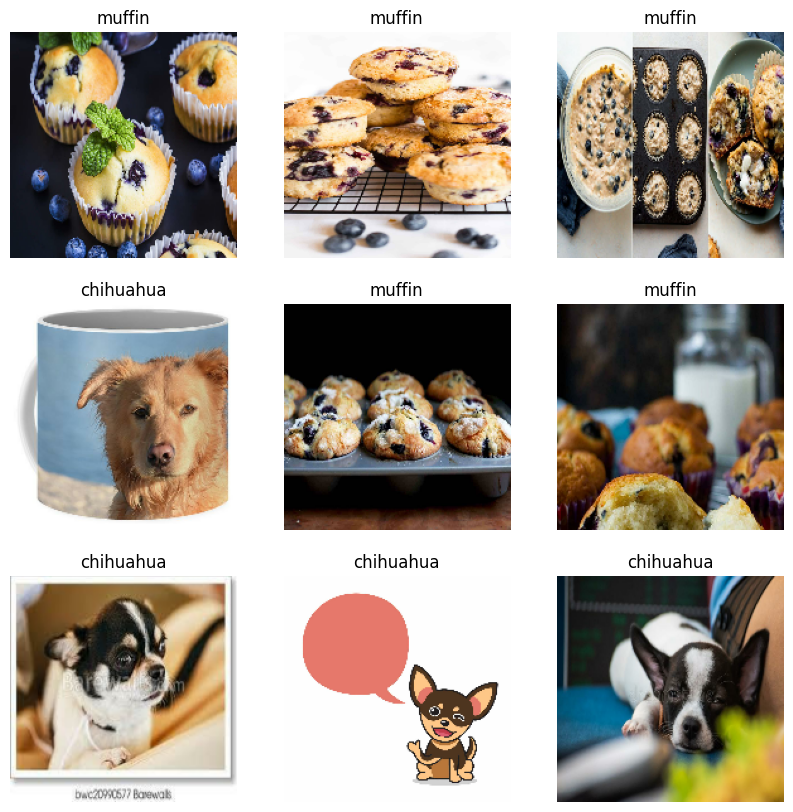

In [29]:
image_batch, label_batch = next(iter(dog_muffin_list_train))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

#### 1.2. The shortcut - ```tf.keras.utils.image_dataset_from_directory```



In [30]:
batch_size = 32
image_size = (180, 180) # default = (256, 256)
data_dir = "/content/gdrive/MyDrive/dog_vs_muffin_test"


In [31]:
# dog_muffin_ds = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/dog_vs_muffin_test", label_mode = "categorical")

In [32]:
dog_muffin_train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 42,
  image_size=image_size,
  batch_size=batch_size)

Found 1184 files belonging to 2 classes.
Using 948 files for training.


In [33]:
dog_muffin_val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 42,
  image_size = image_size,
  batch_size  = batch_size)

Found 1184 files belonging to 2 classes.
Using 236 files for validation.


In [34]:
class_names = dog_muffin_train.class_names
class_names

['chihuahua', 'muffin']

In [35]:
# dataset = dataset.shuffle(dataset.cardinality()) for small datasets / filename datasets only; loads the whole dataset in memory

In [44]:
# dog_muffin_test.shuffle(5)

In [45]:
# fig, axs = plt.subplots(2,2, figsize=(10, 8))
# axs = axs.ravel()

# for i, (image, label) in dog_muffin_test.shuffle(346).enumerate():
#   if i >= 4:
#     print((image.shape, label.shape))
#     break

#   axs[i].imshow(image[0]/255)
#   axs[i].set_title(f"image {i} - label: {label[0].numpy()}")


# plt.show()


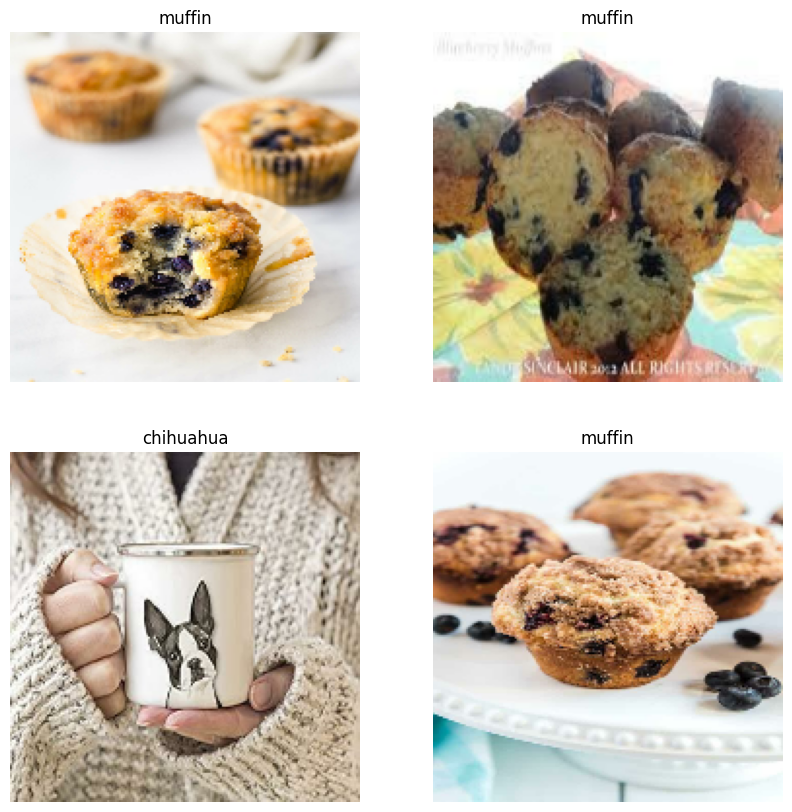

In [46]:
plt.figure(figsize=(10, 10))
for images, labels in dog_muffin_train.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [47]:
# dog_muffin_test.batch(2)

In [48]:
for image_batch, labels_batch in dog_muffin_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Standartize

In [49]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [50]:
normalized_ds = dog_muffin_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9616014


In [51]:
AUTOTUNE = tf.data.AUTOTUNE

dog_muffin_train = dog_muffin_train.cache().prefetch(buffer_size=AUTOTUNE)
dog_muffin_val = dog_muffin_val.cache().prefetch(buffer_size=AUTOTUNE)